In [40]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

In [41]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Preparation
train_dir = "../../data4/train"
validation_dir = "../../data4/validation"
batch_size = 32
image_size = (224, 224)

# Augment training data and rescale
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=30,       # Random rotation
    zoom_range=0.3,          # Random zoom
    horizontal_flip=True,    # Random horizontal flip
    brightness_range=[0.8, 1.2],  # Random brightness
    width_shift_range=0.2,   # Horizontal shift
    height_shift_range=0.2,  # Vertical shift
    shear_range=0.2,         # Shearing
    fill_mode="nearest"      # Fill empty pixels
)

# Only rescale validation data
validation_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Create training and validation generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'  # Changed to 'categorical' for multi-class classification
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Extract number of classes
num_classes = train_generator.num_classes


Found 5999 images belonging to 4 classes.
Found 1672 images belonging to 4 classes.


In [42]:
# Load VGG16 and build the model
def build_vgg16_model(input_shape=(224, 224, 3), num_classes=4, fine_tune_at=15):
    base_model = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # Freeze base model layers initially

    # Add classification head
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model, base_model


In [43]:
# Plotting function
def plot_training_results(history, metrics=["accuracy", "loss"]):
    for metric in metrics:
        plt.figure()
        plt.plot(history.history[metric], label=f"Training {metric}")
        plt.plot(history.history[f"val_{metric}"], label=f"Validation {metric}")
        plt.title(f"Training vs Validation {metric.capitalize()}")
        plt.xlabel("Epochs")
        plt.ylabel(metric.capitalize())
        plt.legend()
        plt.show()

In [ ]:
# Callbacks for better generalization
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Build and train the model
model, base_model = build_vgg16_model(input_shape=(224, 224, 3), num_classes=len(train_generator.class_indices))
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    verbose=1,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/20


/Users/liraj/.pyenv/versions/3.9.4/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 77/188 ━━━━━━━━━━━━━━━━━━━━ 10:39 6s/step - accuracy: 0.3248 - loss: 3.6613

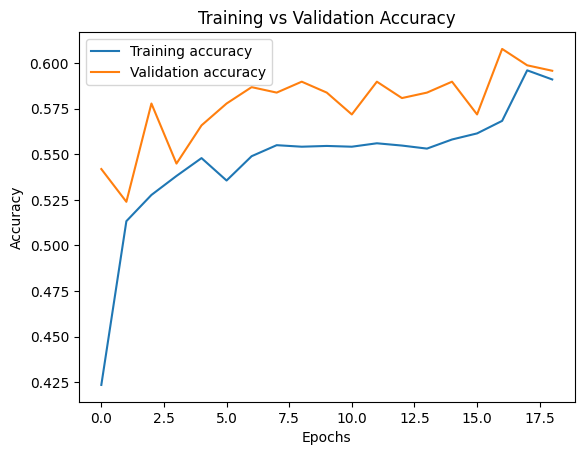

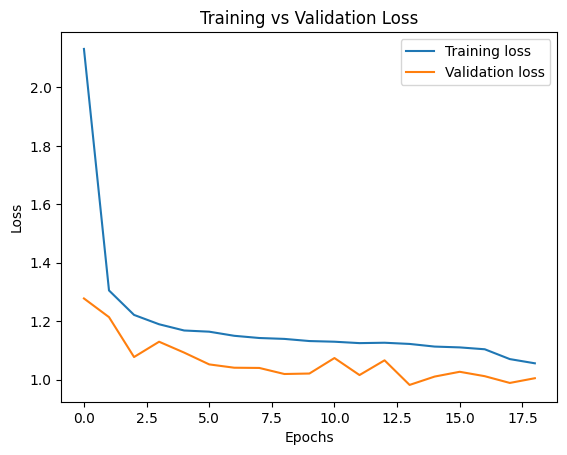

In [ ]:
plot_training_results(history, metrics=["accuracy", "loss"])


In [ ]:
# Fine-tune the base model
base_model.trainable = True
for layer in base_model.layers[:15]:  # Freeze the first `fine_tune_at` layers
    layer.trainable = False

# Recompile and train
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
fine_tune_history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    verbose=1,
    batch_size=batch_size,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 601s 4s/step - accuracy: 0.6793 - loss: 0.8439 - val_accuracy: 0.6647 - val_loss: 0.8612 - learning_rate: 1.0000e-05
Epoch 2/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 588s 4s/step - accuracy: 0.7066 - loss: 0.8001 - val_accuracy: 0.6707 - val_loss: 0.8422 - learning_rate: 1.0000e-05
Epoch 3/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 587s 4s/step - accuracy: 0.7125 - loss: 0.8011 - val_accuracy: 0.6826 - val_loss: 0.8515 - learning_rate: 1.0000e-05
Epoch 4/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 637s 4s/step - accuracy: 0.7183 - loss: 0.7837 - val_accuracy: 0.6796 - val_loss: 0.9201 - learning_rate: 1.0000e-05
Epoch 5/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 687s 5s/step - accuracy: 0.7162 - loss: 0.7726 - val_accuracy: 0.6976 - val_loss: 0.8137 - learning_rate: 1.0000e-05
Epoch 6/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 707s 5s/step - accuracy: 0.7210 - loss: 0.7902 - val_accuracy: 0.6856 - val_loss: 0.8589 - learning_rate: 1.0000e-05
Epoch 7/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 693s 5s/step - acc

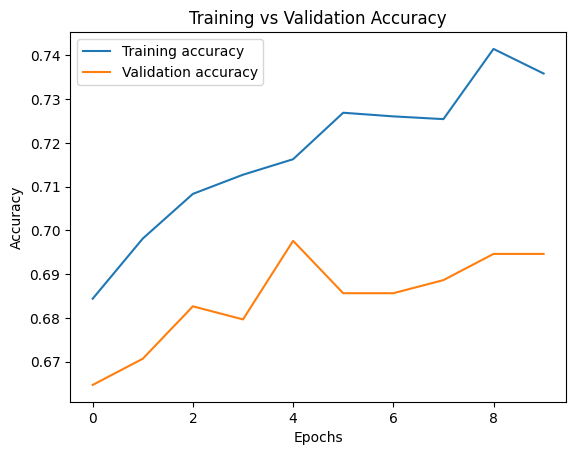

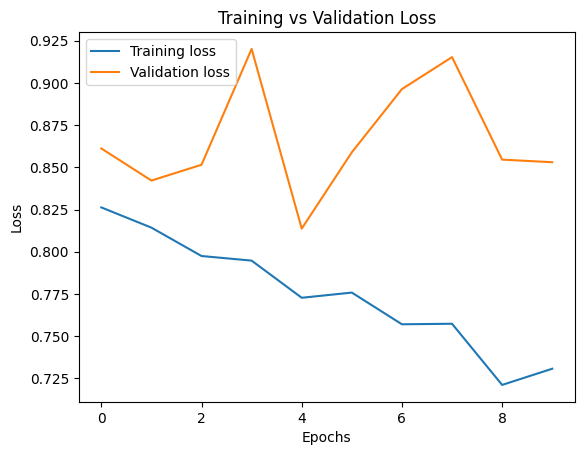

11/11 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step - accuracy: 0.7146 - loss: 0.7902
Validation Loss: 0.81
Validation Accuracy: 0.70


In [ ]:
# Plot metrics
plot_training_results(fine_tune_history, metrics=["accuracy", "loss"])

# Evaluate the model
results = model.evaluate(validation_generator)
print(f"Validation Loss: {results[0]:.2f}")
print(f"Validation Accuracy: {results[1]:.2f}")


In [ ]:
# Save the trained model
model.save("../../models/Improved_vgg16_model.keras")